In [52]:
import os
import sys
import matplotlib.pyplot as plt
import numpy as np

import scipy
import anndata
import random
import pandas as pd
import warnings
import matplotlib.patches as mpatches
import scanpy as sc

import csv
import concurrent
import ast
import matplotlib as mpl
import matplotlib.patches as mpatches
from scipy import stats

from collections import OrderedDict
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
from sklearn.preprocessing import scale

from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import NeighborhoodComponentsAnalysis
from matplotlib import cm
from matplotlib.lines import Line2D

from scipy.stats import zscore
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial.distance import pdist, squareform

import upsetplot

import seaborn as sns

def nd(arr):
    return np.asarray(arr).reshape(-1)

# Violin plot functions

def vplot(y, ax):
    parts = ax.violinplot(
        y, showmeans=False, showmedians=False,
        showextrema=False)

    mean = y.mean()
    ax.scatter(1, mean, zorder=10, color="white")
    
    x = np.random.normal(1, 0.04, size=len(y))
    ax.scatter(x, y, color="k", s=1)
    
    for pc in parts['bodies']:
        pc.set_facecolor('#D43F3A')
        pc.set_edgecolor('black')
        pc.set_alpha(1)
    
    ax.set_xticks([1])
    ax.set_xticklabels([""])
    return ax

def vplot_de(x, unique, specific_gene, specific_cluster, ax):
    unique = unique.astype(str)
    labels = unique
    lidx = np.arange(1, len(labels)+1)  # the label locations
    midx = np.where(unique==specific_cluster)[0][0]
    
    
    parts = ax.violinplot(x, showmedians=False, showextrema=False)
    for pcidx, pc in enumerate(parts['bodies']):
        pc.set_facecolor('grey')
        pc.set_edgecolor('black')
        pc.set_alpha(1)
        if pcidx == midx:
            pc.set_facecolor('#D43F3A')
            
    mean = [np.mean(i) for i in x]
    ax.scatter(lidx, mean, marker='o', color='white', s=30, zorder=3)
    
    ax.set_ylabel("$log(CPM + 1)$".format(specific_gene))
    ax.set_xticks(lidx)
    ax.set_xticklabels(labels, rotation=0, ha="center")
    ax.set_title("{} gene in cluster {}".format(specific_gene, specific_cluster))
    
    return ax

warnings.filterwarnings('ignore')

fsize=20
plt.rcParams.update({'font.size': fsize})

plt.rcParams["figure.dpi"] = 300



In [53]:
# Path to count matrices (transcript-level)
counts_dir = "splitseq_out/quant_unfiltered/"
matrix_path=counts_dir+"../counts_unfiltered/cells_x_tcc.mtx" # matrix_path=counts_dir+"matrix.abundance.mtx" # 
#matrix_path=counts_dir+"matrix.abundance.mtx"
transcripts_path=counts_dir+"transcripts.txt"
barcodes_path=counts_dir+"../counts_unfiltered/cells_x_tcc.barcodes.txt"
# Path to count matrices (gene-level)
counts_dir_gene = "splitseq_out/counts_unfiltered/"
matrix_path_gene=counts_dir_gene+"cells_x_genes.total.mtx"
matrix_path_gene_M=counts_dir_gene+"cells_x_genes.mature.mtx"
matrix_path_gene_N=counts_dir_gene+"cells_x_genes.nascent.mtx"
matrix_path_gene_A=counts_dir_gene+"cells_x_genes.ambiguous.mtx"
genes_path=counts_dir_gene+"cells_x_genes.genes.txt"
barcodes_path_gene=counts_dir_gene+"cells_x_genes.barcodes.txt"
# Path to annotation file
annotation_file="Smart3.PBMC.annotated.txt"

In [54]:
# Load transcript-level matrix

with open(transcripts_path, 'r') as f:
    transcripts = [line.strip().split()[0] for line in f]

with open(barcodes_path, 'r') as f:
    barcodes = [line.strip() for line in f]

with open(counts_dir_gene+"cells_x_genes.barcodes.prefix.txt", 'r') as f:
    barcodes_prefix = [line.strip() for line in f]

data = anndata.AnnData(scipy.io.mmread(matrix_path).tocsr()).T  # float32 matrix
data = data.T

In [55]:
# Load gene-level (total N+A+M) matrix

with open(genes_path, 'r') as f:
    genes = [line.strip().split()[0] for line in f]

with open(barcodes_path_gene, 'r') as f:
    barcodes_gene = [line.strip() for line in f]

data_gene = anndata.AnnData(scipy.io.mmread(matrix_path_gene).tocsr()).T  # float32 matrix
data_gene = data_gene.T

# Load gene-level M matrix

data_gene_M = anndata.AnnData(scipy.io.mmread(matrix_path_gene_M).tocsr()).T  # float32 matrix
data_gene_M = data_gene_M.T


# Load gene-level A matrix

data_gene_A = anndata.AnnData(scipy.io.mmread(matrix_path_gene_A).tocsr()).T  # float32 matrix
data_gene_A = data_gene_A.T


# Load gene-level N matrix

data_gene_N = anndata.AnnData(scipy.io.mmread(matrix_path_gene_N).tocsr()).T  # float32 matrix
data_gene_N = data_gene_N.T


In [56]:
# Just make some copies so it's easy to revisit the raw matrices later
xx = data.copy()
data = xx.copy()
xx_gene = data_gene.copy()
data_gene = xx_gene.copy()
xx_gene_A = data_gene_A.copy()
data_gene_A = xx_gene_A.copy()
xx_gene_M = data_gene_M.copy()
data_gene_M = xx_gene_M.copy()
xx_gene_N = data_gene_N.copy()
data_gene_N = xx_gene_N.copy()

In [57]:
# Load/reload the raw matrices
data = xx.copy()
data_gene = xx_gene.copy()
data_gene_A = xx_gene_A.copy()
data_gene_M = xx_gene_M.copy()
data_gene_N = xx_gene_N.copy()

In [58]:
data.obs_names = barcodes
# data.var_names = transcripts #
# data.var['transcript_id'] = transcripts #
# data.var['transcript_name'] = transcripts #

data_gene.obs_names = barcodes_gene
data_gene.var_names = genes
data_gene.var['gene_id'] = genes
data_gene.var['gene_name'] = genes

data_gene_A.obs_names = barcodes_gene
data_gene_A.var_names = genes
data_gene_A.var['gene_id'] = genes
data_gene_A.var['gene_name'] = genes

data_gene_M.obs_names = barcodes_gene
data_gene_M.var_names = genes
data_gene_M.var['gene_id'] = genes
data_gene_M.var['gene_name'] = genes

data_gene_N.obs_names = barcodes_gene
data_gene_N.var_names = genes
data_gene_N.var['gene_id'] = genes
data_gene_N.var['gene_name'] = genes

# Barcode mapping and filtering

mapping_df = pd.read_csv(annotation_file, sep='\t')
mapping = pd.Series(mapping_df.clusterName.values, index=mapping_df.cellID).to_dict()

data.obs['id'] = data.obs.index.map(mapping)
data_gene.obs['id'] = data_gene.obs.index.map(mapping)
data_gene_A.obs['id'] = data_gene_A.obs.index.map(mapping)
data_gene_M.obs['id'] = data_gene_M.obs.index.map(mapping)
data_gene_N.obs['id'] = data_gene_N.obs.index.map(mapping)

data.obs['id'] = barcodes_prefix
data_gene.obs['id'] = barcodes_prefix

In [59]:
data

AnnData object with n_obs × n_vars = 1678 × 210379
    obs: 'id'

In [60]:
data.obs["cell_counts"] = data.X.sum(axis=1)
data.var["transcript_counts"] = nd(data.X.sum(axis=0))
data.obs["n_transcripts"] = nd((data.X>0).sum(axis=1))
data.var["n_cells"] = nd((data.X>0).sum(axis=0))
# data.var_names = list(data.var.transcript_name) #
# data.var_names_make_unique() #

data_gene.obs["cell_counts"] = data_gene.X.sum(axis=1)
data_gene.var["gene_counts"] = nd(data_gene.X.sum(axis=0))
data_gene.obs["n_genes"] = nd((data_gene.X>0).sum(axis=1))
data_gene.var["n_cells"] = nd((data_gene.X>0).sum(axis=0))
data_gene.var_names = list(data_gene.var.gene_name)
data_gene.var_names_make_unique()


data_gene_A.obs["cell_counts"] = data_gene_A.X.sum(axis=1)
data_gene_A.var["gene_counts"] = nd(data_gene_A.X.sum(axis=0))
data_gene_A.obs["n_genes"] = nd((data_gene_A.X>0).sum(axis=1))
data_gene_A.var["n_cells"] = nd((data_gene_A.X>0).sum(axis=0))
data_gene_A.var_names = list(data_gene_A.var.gene_name)
data_gene_A.var_names_make_unique()

data_gene_M.obs["cell_counts"] = data_gene_M.X.sum(axis=1)
data_gene_M.var["gene_counts"] = nd(data_gene_M.X.sum(axis=0))
data_gene_M.obs["n_genes"] = nd((data_gene_M.X>0).sum(axis=1))
data_gene_M.var["n_cells"] = nd((data_gene_M.X>0).sum(axis=0))
data_gene_M.var_names = list(data_gene_M.var.gene_name)
data_gene_M.var_names_make_unique()

data_gene_N.obs["cell_counts"] = data_gene_N.X.sum(axis=1)
data_gene_N.var["gene_counts"] = nd(data_gene_N.X.sum(axis=0))
data_gene_N.obs["n_genes"] = nd((data_gene_N.X>0).sum(axis=1))
data_gene_N.var["n_cells"] = nd((data_gene_N.X>0).sum(axis=0))
data_gene_N.var_names = list(data_gene_N.var.gene_name)
data_gene_N.var_names_make_unique()

print(data)

AnnData object with n_obs × n_vars = 1678 × 210379
    obs: 'id', 'cell_counts', 'n_transcripts'
    var: 'transcript_counts', 'n_cells'


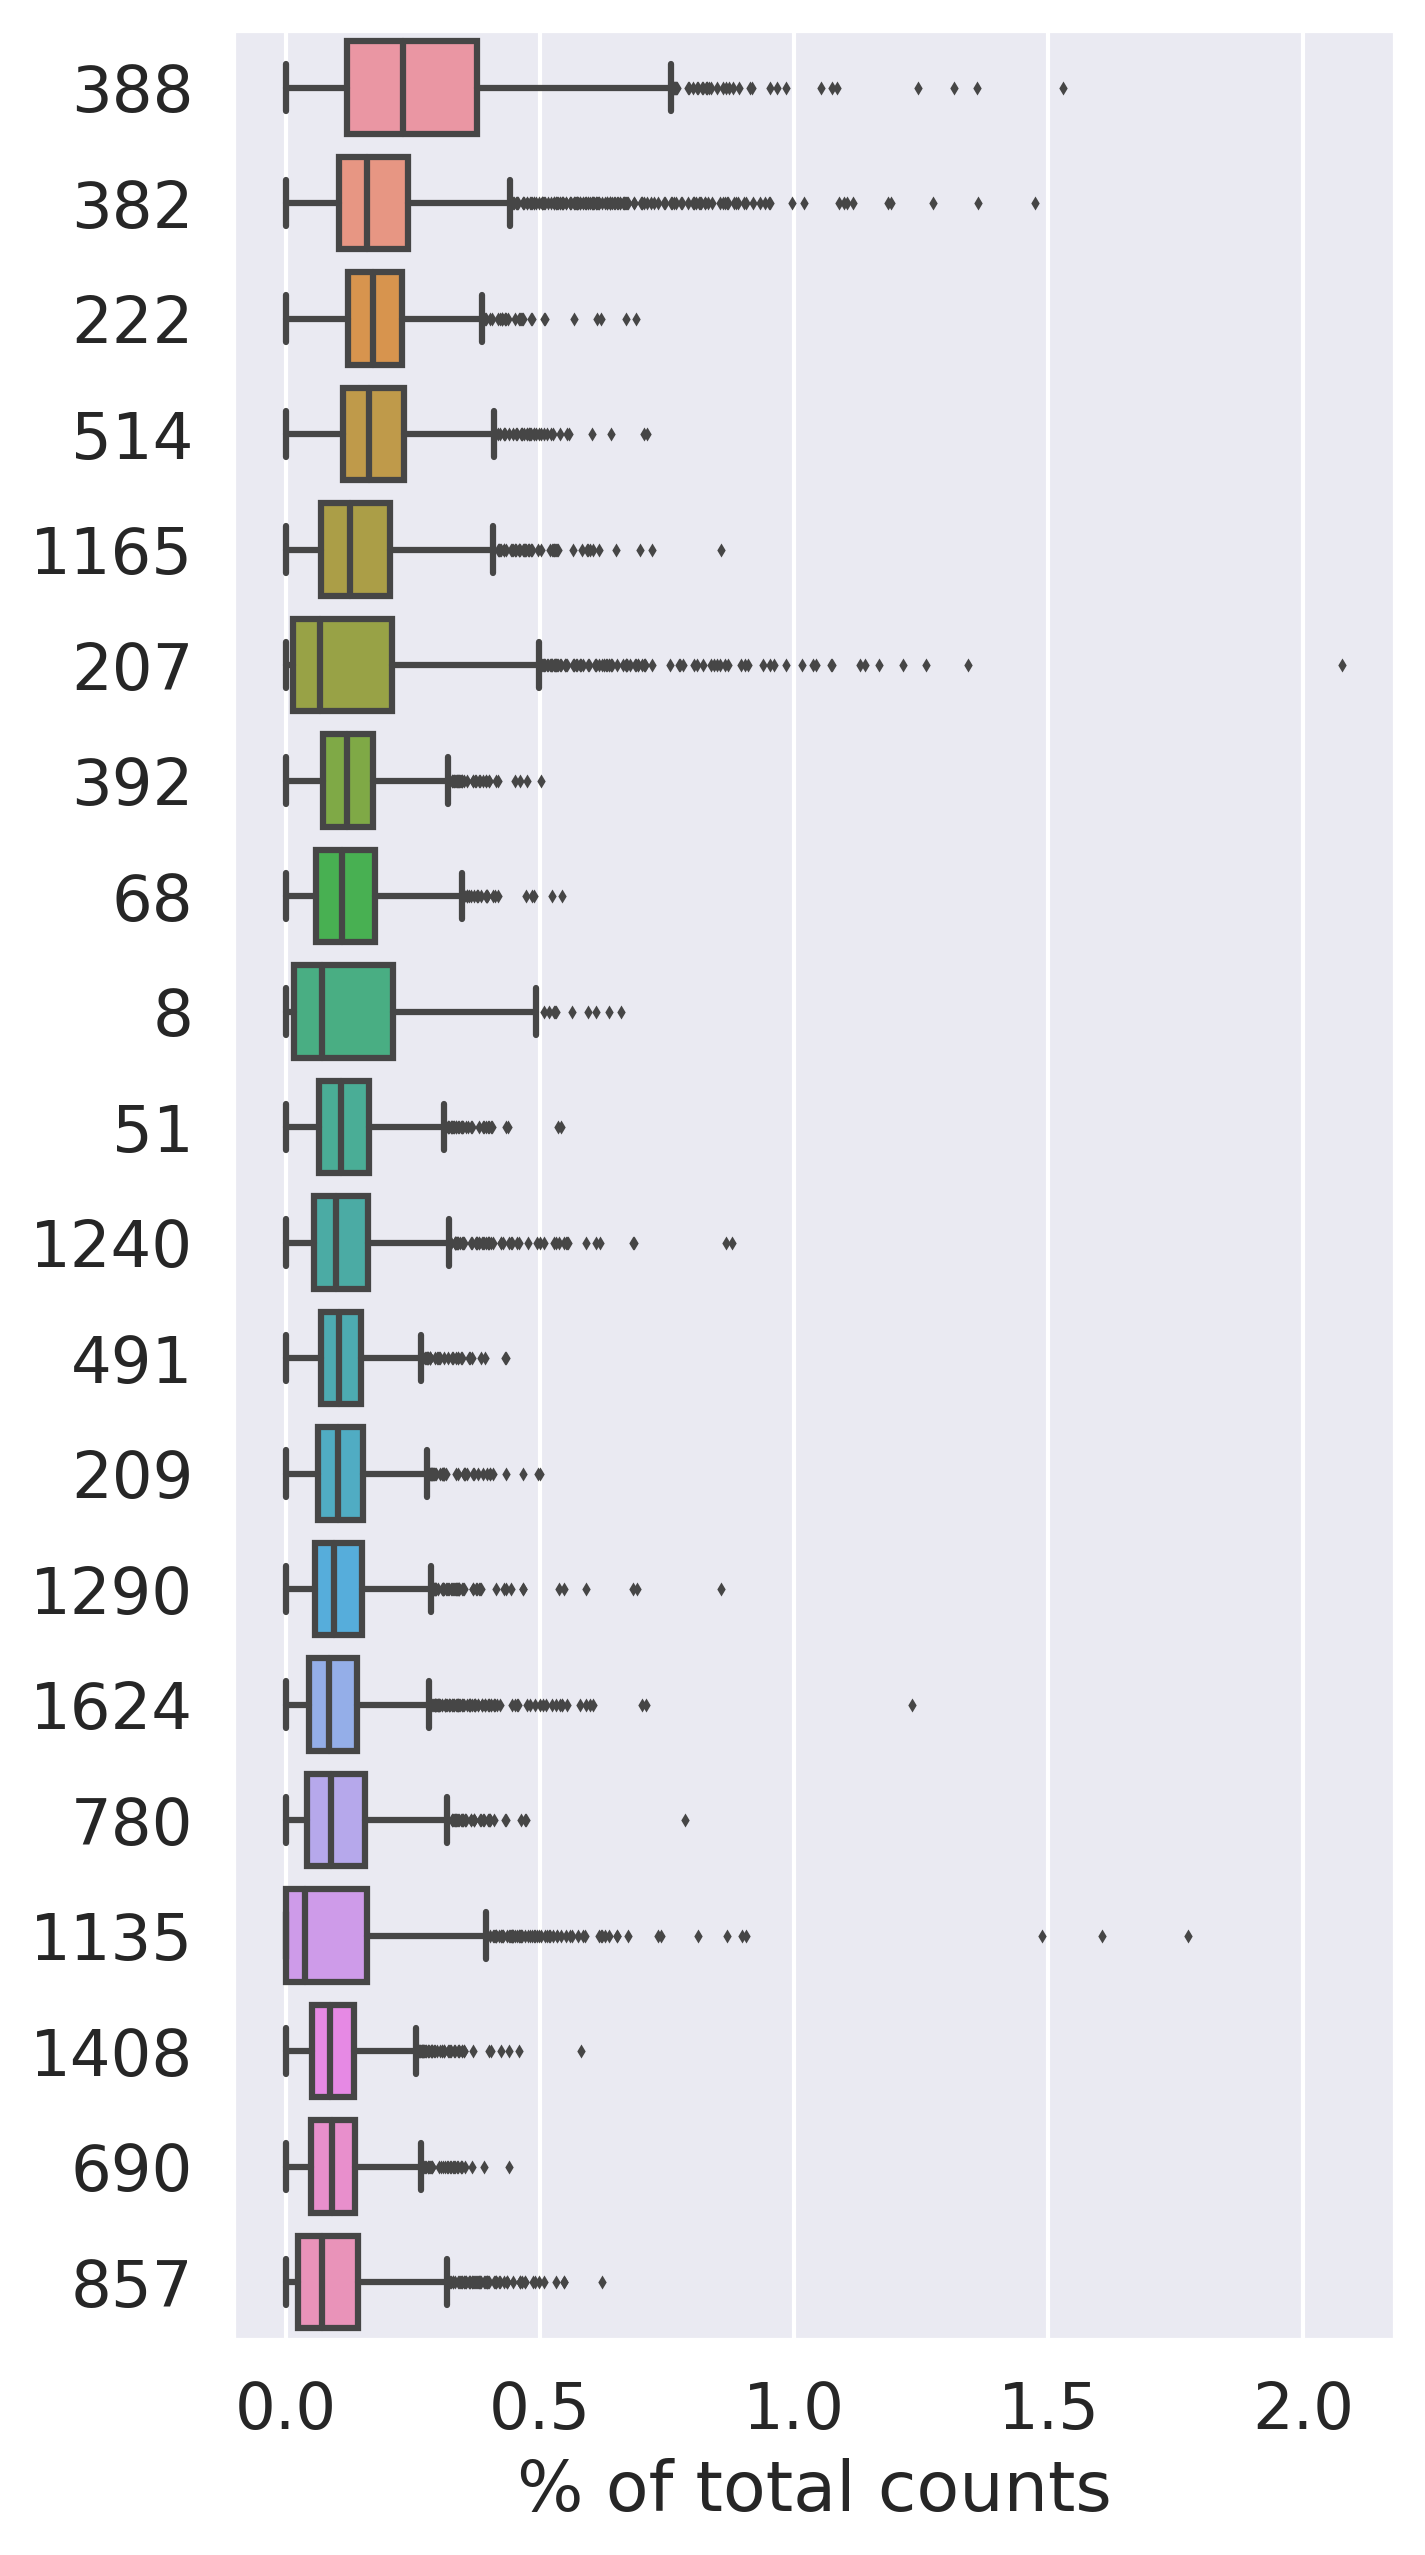

In [61]:
fig, ax = plt.subplots(figsize=(5, 10))
sc.pl.highest_expr_genes(data, n_top=20, ax = ax)

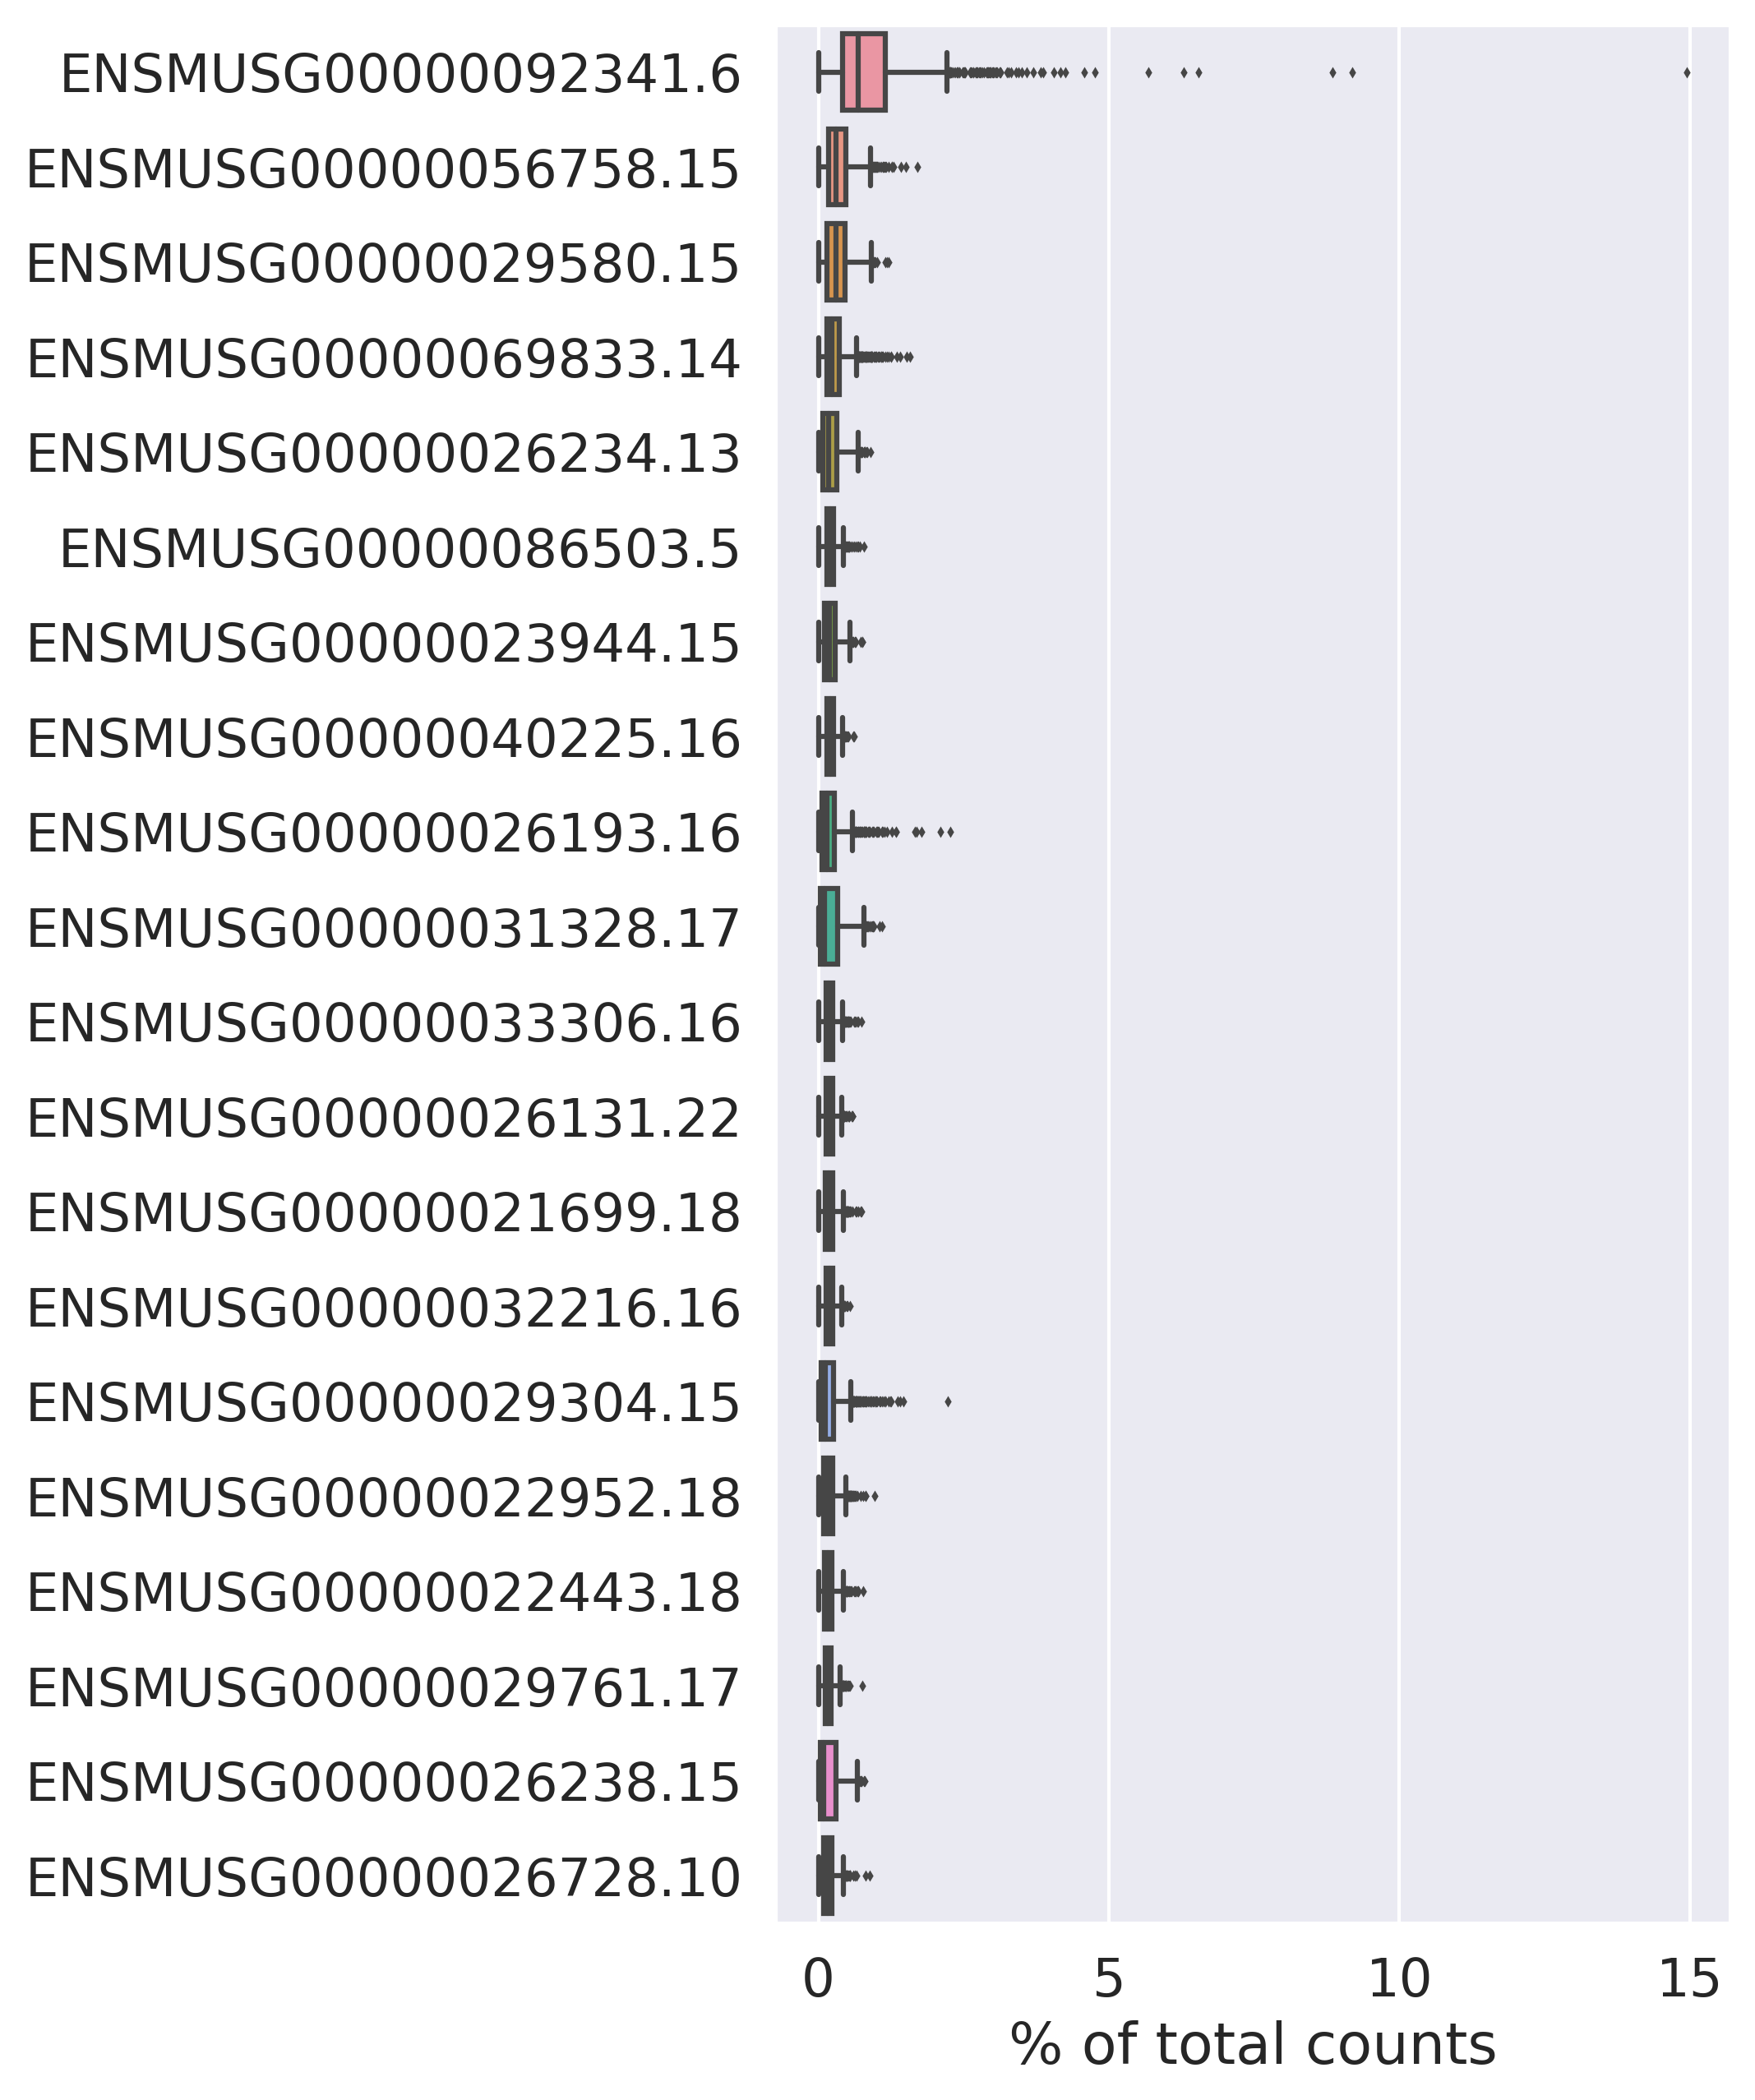

In [62]:
fig, ax = plt.subplots(figsize=(5, 10))
sc.pl.highest_expr_genes(data_gene, n_top=20, ax = ax)

In [63]:
data

AnnData object with n_obs × n_vars = 1678 × 210379
    obs: 'id', 'cell_counts', 'n_transcripts'
    var: 'transcript_counts', 'n_cells'

In [64]:
x = data.copy()

In [65]:
ec_mapping = {}
with open(counts_dir+"../counts_unfiltered/cells_x_tcc.ec.txt", 'r') as f:
    for line in f:
        key, value = line.strip().split()
        ec_mapping[int(key)] = [int(x) for x in value.split(',')]

with open(counts_dir+"../transcripts.txt", 'r') as f:
    transcript_list = [line.strip() for line in f]

def map_transcripts(indices):
    return ','.join([transcript_list[i] for i in indices])

data.var['transcript_names'] = data.var.index.map(lambda idx: map_transcripts(ec_mapping[int(idx)]))
ec_mapping = ec_mapping.copy()

In [66]:
transcript_to_gene = {}
with open('STARsoloManuscript/genomes/index/kallisto_0.50.1/mouse/nac_offlist_1/g', 'r') as f:
    for line in f:
        transcript, gene = line.strip().split()[0:2]
        transcript_to_gene[transcript] = gene

# Step 2: Map transcript names to gene names and ensure uniqueness
def map_genes(transcript_list):
    # Convert transcript names to gene names and use a set to ensure uniqueness
    gene_set = {transcript_to_gene[transcript] for transcript in transcript_list.split(',')}
    return ','.join(sorted(gene_set))  # Sort the genes to have a consistent order

# Step 3: Apply the mapping to the 'transcript_names' column to create the 'gene_names' column
data.var['gene_names'] = data.var['transcript_names'].map(map_genes)



In [67]:
data.var

,transcript_counts,n_cells,transcript_names,gene_names
0,1972.0,1002,ENSMUSG00000021027.18,ENSMUSG00000021027.18
1,3545.0,1192,"ENSMUST00000000804.7,ENSMUSG00000000787.13",ENSMUSG00000000787.13
2,3080.0,1147,ENSMUSG00000071064.16,ENSMUSG00000071064.16
3,2724.0,885,"ENSMUST00000024739.14,ENSMUST00000146770.8,ENS...",ENSMUSG00000023944.15
4,3653.0,1264,ENSMUSG00000031659.14,ENSMUSG00000031659.14
...,...,...,...,...
210374,1.0,1,"ENSMUST00000014339.15,ENSMUST00000146840.3,ENS...",ENSMUSG00000014195.17
210375,1.0,1,"ENSMUST00000057910.16,ENSMUST00000182260.8,ENS...",ENSMUSG00000047417.19
210376,1.0,1,"ENSMUST00000037739.8,ENSMUST00000226740.2,ENSM...",ENSMUSG00000042354.8
210377,1.0,1,"ENSMUST00000168431.7,ENSMUST00000191865.2,ENSM...",ENSMUSG00000026074.16


In [68]:
mapping = {
    'AAAAAAAAAAAAAAAA': 0,
    'AAAAAAAAAAAAAAAC': 1,
    'AAAAAAAAAAAAAAAG': 0,
    'AAAAAAAAAAAAAAAT': 1,
    'AAAAAAAAAAAAAACA': 0,
    'AAAAAAAAAAAAAACC': 1,
    'AAAAAAAAAAAAAACG': 0,
    'AAAAAAAAAAAAAACT': 1,
    'AAAAAAAAAAAAAAGA': 0,
    'AAAAAAAAAAAAAAGC': 1,
    'AAAAAAAAAAAAAAGG': 0,
    'AAAAAAAAAAAAAAGT': 1,
    'AAAAAAAAAAAAAATA': 0,
    'AAAAAAAAAAAAAATC': 1
}

data_gene.obs['id_int'] = data_gene.obs['id'].map(mapping)
data.obs['id_int'] = data.obs['id'].map(mapping)

In [69]:
x = data.copy()
xg = data_gene.copy()

In [70]:
data = x.copy()
data_gene = xg.copy()

In [71]:
# Normalize TCCs

scale_num = 10000
data.layers["norm"] = normalize(data.X, norm="l1", axis=1)*scale_num
data.layers["log1p"] = np.log1p(data.layers["norm"])
data.uns = OrderedDict([("log1p", {"base":None})])
data.X = data.layers["log1p"]

# Normalize genes to CPMs

# Step 1: Calculate total counts per cell
total_counts = np.array(data_gene.X.sum(axis=1)).flatten()  # Summing across genes (rows) for each cell (columns)

# Step 2: Normalize counts to CPM
data_gene.X = scipy.sparse.diags(1e6 / total_counts) @ data_gene.X  # Apply the normalization in a memory-efficient way

In [72]:
gene_name = 'ENSMUSG00000030079.16'

# Filter the var indices based on the presence of gene_name in the gene_names column
#selected_indices = data.var.index[data.var['gene_names'].str.contains(gene_name)]
selected_indices = data.var.index[data.var['gene_names'] == gene_name]

# Create a new anndata object that is a subset of the original data
subset_data = data[:, selected_indices].copy()

subset_data_0 = subset_data[subset_data.obs['id'].isin([key for key, value in mapping.items() if value == 0]), :]
subset_data_1 = subset_data[subset_data.obs['id'].isin([key for key, value in mapping.items() if value == 1]), :]

In [73]:
# Extract the counts matrix
counts_matrix_0 = subset_data_0.X.toarray()  # Convert to dense array if it's sparse
counts_matrix_1 = subset_data_1.X.toarray()  # Convert to dense array if it's sparse

# Get the gene (index) names and cell (obs) names
gene_names = subset_data.var.index
cell_names_0 = subset_data_0.obs.index
cell_names_1 = subset_data_1.obs.index

# Create a DataFrame for easier manipulation and plotting
heatmap_data_0 = pd.DataFrame(counts_matrix_0.T, index=gene_names, columns=cell_names_0)
heatmap_data_1 = pd.DataFrame(counts_matrix_1.T, index=gene_names, columns=cell_names_1)

# Filter the heatmap_data to keep only these cells

non_zero_cells = (heatmap_data_0 != 0).any(axis=0)
heatmap_data_0 = heatmap_data_0.loc[:, non_zero_cells]
non_zero_cells = (heatmap_data_1 != 0).any(axis=0)
heatmap_data_1 = heatmap_data_1.loc[:, non_zero_cells]


<Figure size 2100x600 with 0 Axes>

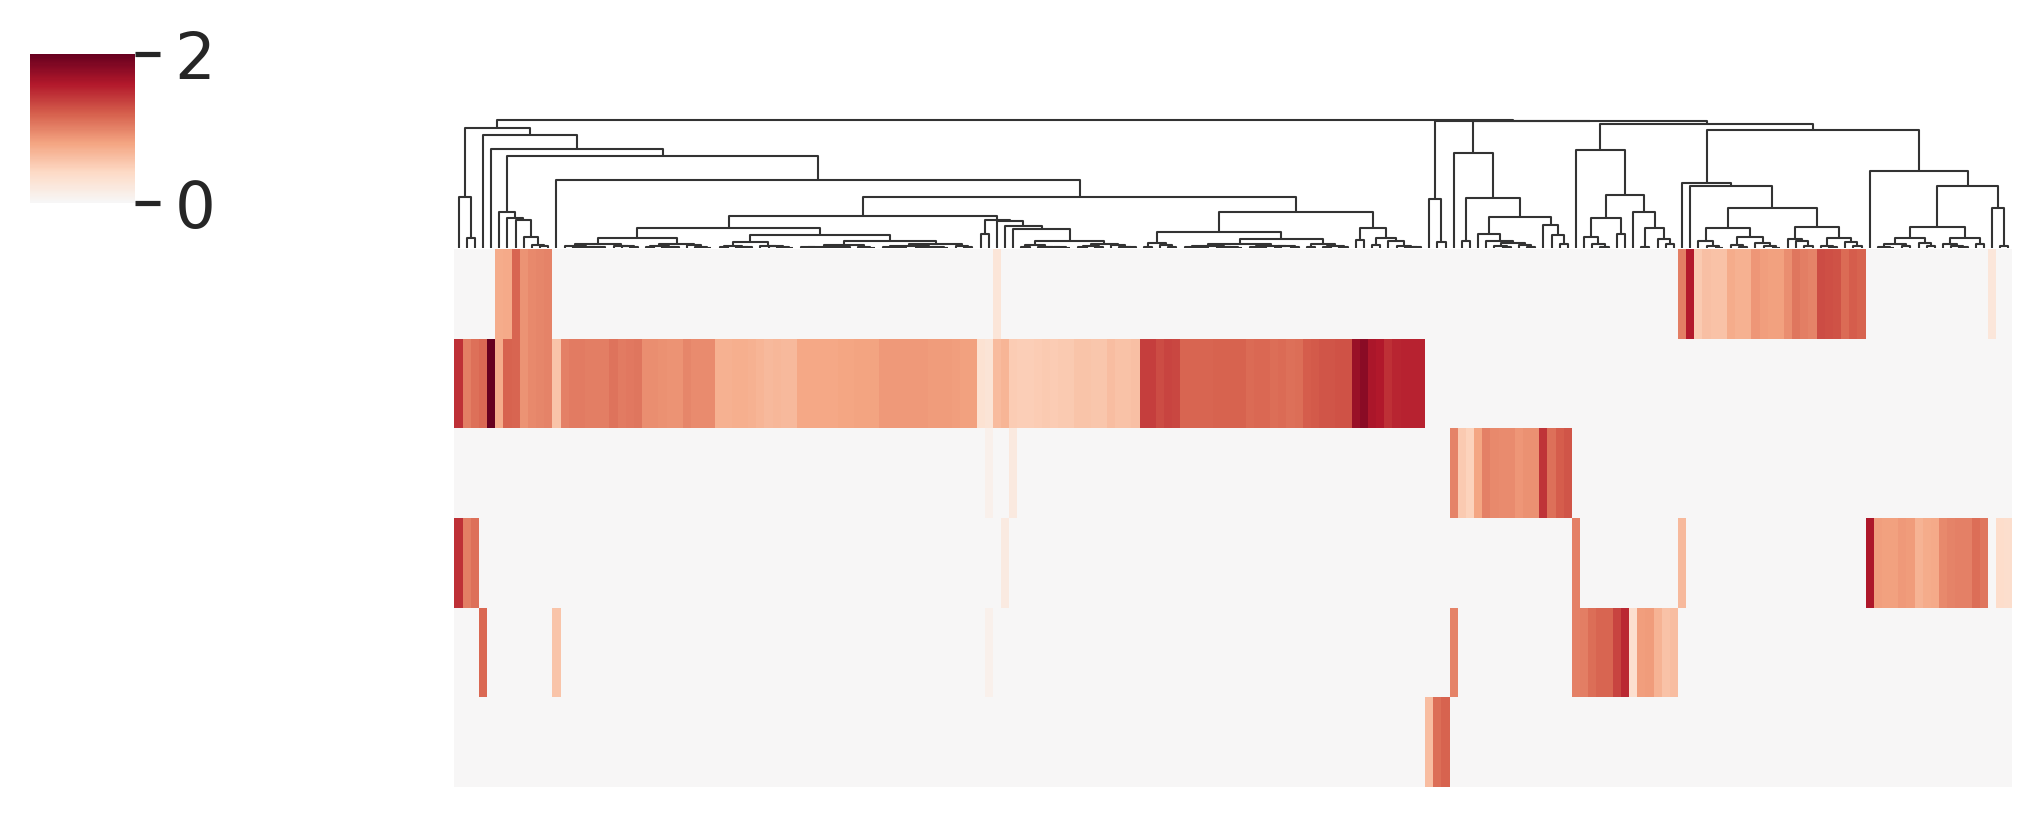

In [74]:
plot_data = heatmap_data_0.copy()
plt.figure(figsize=(7, 2))
num_ecs = len(list(plot_data.index))
yticklabels=list(map(chr, range(97, 97+num_ecs)))
sns.set(font_scale=1.4)
g = sns.clustermap(plot_data, metric="euclidean", method="average", cmap="RdBu_r", yticklabels=False,
               xticklabels=False, row_cluster=False, center=0, vmin=0, vmax=2.0, figsize=(7,2.75))
#plt.setp(g.ax_heatmap.get_yticklabels(), rotation=0)
plt.show()

In [75]:
[map_transcripts(ec_mapping[int(ec)]) for ec in list(heatmap_data_0.index)]

['ENSMUST00000032165.16,ENSMUSG00000030079.16',
 'ENSMUSG00000030079.16',
 'ENSMUST00000032165.16,ENSMUST00000129035.2,ENSMUSG00000030079.16',
 'ENSMUST00000032165.16,ENSMUST00000129035.2',
 'ENSMUST00000032165.16',
 'ENSMUST00000129035.2,ENSMUSG00000030079.16']

<Figure size 2100x825 with 0 Axes>

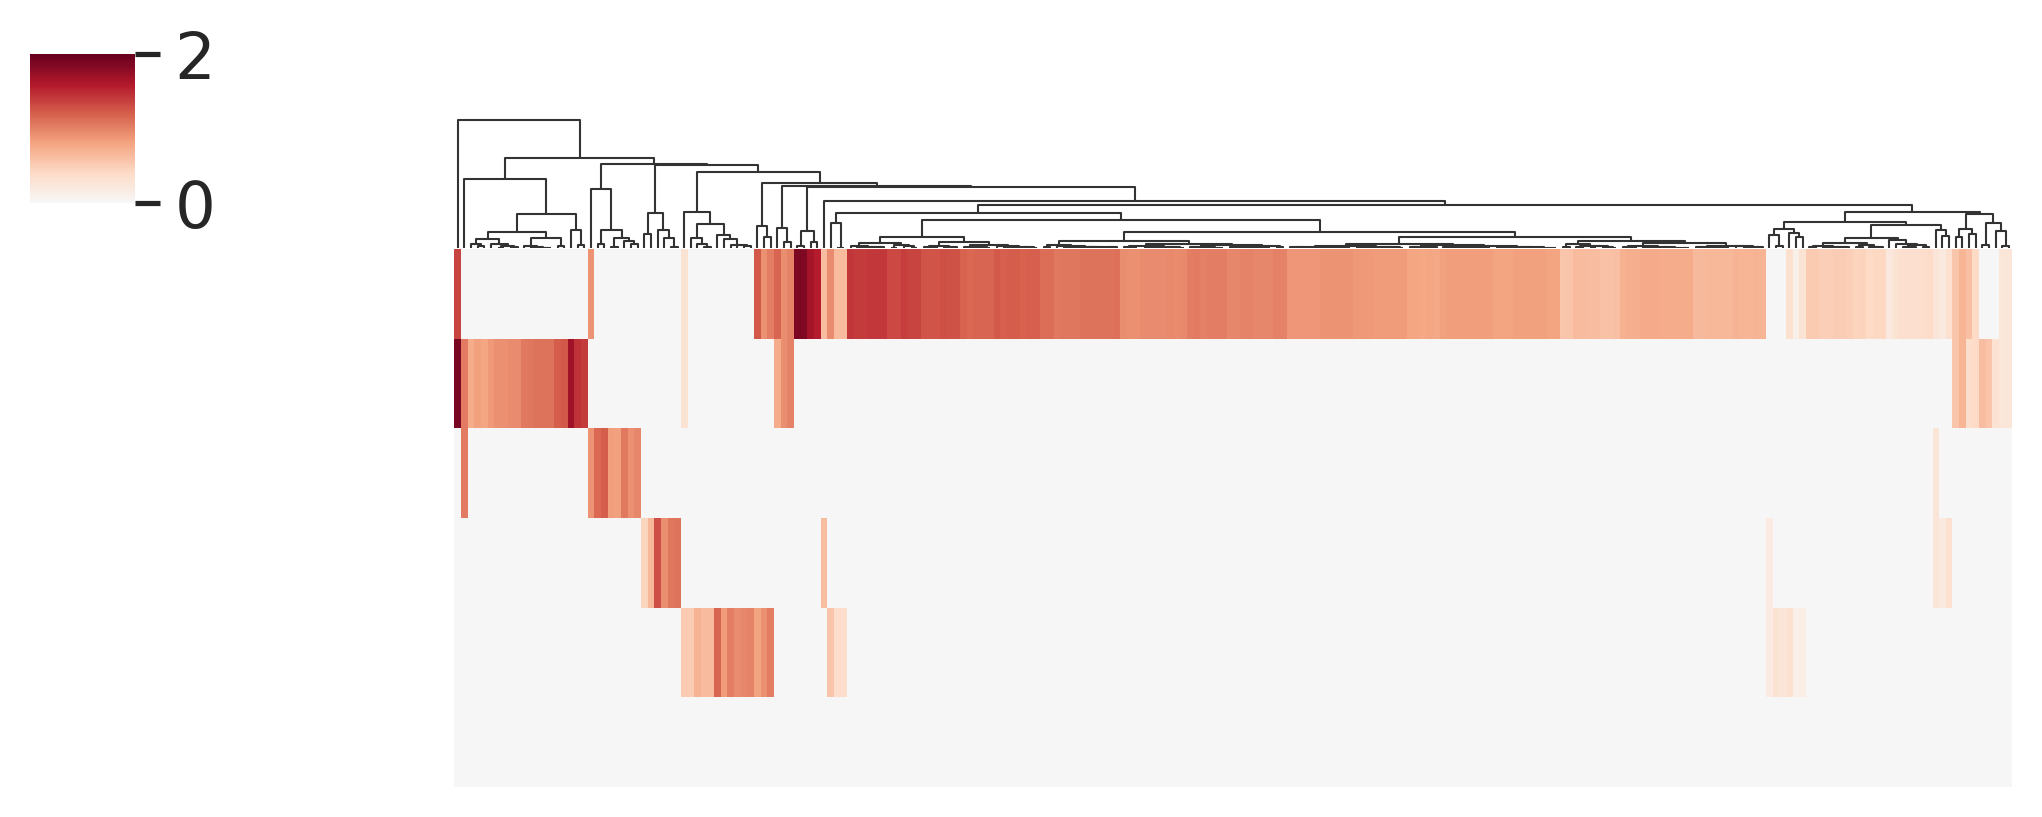

In [76]:
plot_data = heatmap_data_1.copy()
plt.figure(figsize=(7, 2.75))
num_ecs = len(list(plot_data.index))
yticklabels=list(map(chr, range(97, 97+num_ecs)))
sns.set(font_scale=1.4)
g = sns.clustermap(plot_data, metric="euclidean", method="average", cmap="RdBu_r", yticklabels=False,
               xticklabels=False, row_cluster=False, center=0, vmin=0, vmax=2.0, figsize=(7,2.75))
#plt.setp(g.ax_heatmap.get_yticklabels(), rotation=0)
plt.show()

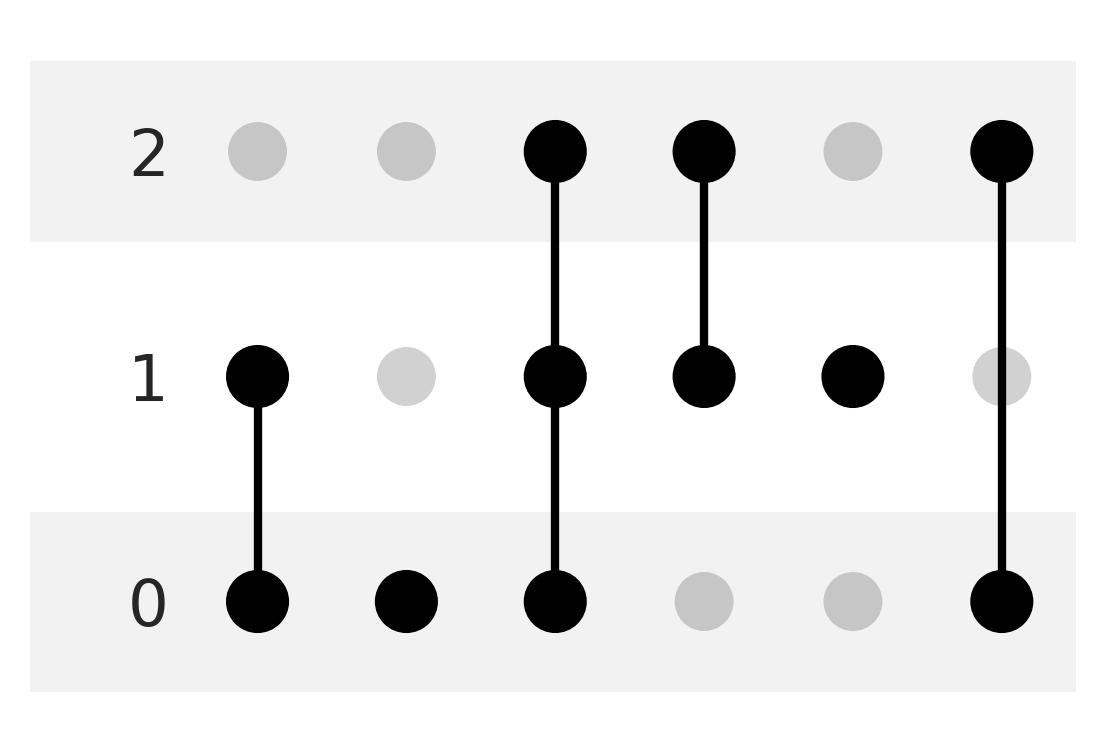

In [77]:
fig = plt.figure(figsize=(4.5, 3))
ud = {
    'Nascent Ruvbl1': '0',
    'Mature Ruvbl1 (ENSMUST00000032165)': '1',
    'Mature Ruvbl1 (ENSMUST00000129035)': '2'
}
example = upsetplot.from_memberships(
    [
     [ud['Nascent Ruvbl1'], ud['Mature Ruvbl1 (ENSMUST00000032165)']],
     [ud['Nascent Ruvbl1']],
     [ud['Nascent Ruvbl1'], ud['Mature Ruvbl1 (ENSMUST00000032165)'], ud['Mature Ruvbl1 (ENSMUST00000129035)']],
     [ud['Mature Ruvbl1 (ENSMUST00000032165)'], ud['Mature Ruvbl1 (ENSMUST00000129035)']],
     [ud['Mature Ruvbl1 (ENSMUST00000032165)']],
     [ud['Nascent Ruvbl1'], ud['Mature Ruvbl1 (ENSMUST00000129035)']],
    ],
    data=[1, 2, 3, 4, 5, 6]
)
up = upsetplot.plot(example, sort_categories_by='input', fig=fig, element_size=None, sort_by='input', totals_plot_elements=0, intersection_plot_elements=0)

plt.show()


In [78]:
[map_transcripts(ec_mapping[int(ec)]) for ec in list(heatmap_data_1.index)]

['ENSMUST00000032165.16,ENSMUSG00000030079.16',
 'ENSMUSG00000030079.16',
 'ENSMUST00000032165.16,ENSMUST00000129035.2,ENSMUSG00000030079.16',
 'ENSMUST00000032165.16,ENSMUST00000129035.2',
 'ENSMUST00000032165.16',
 'ENSMUST00000129035.2,ENSMUSG00000030079.16']

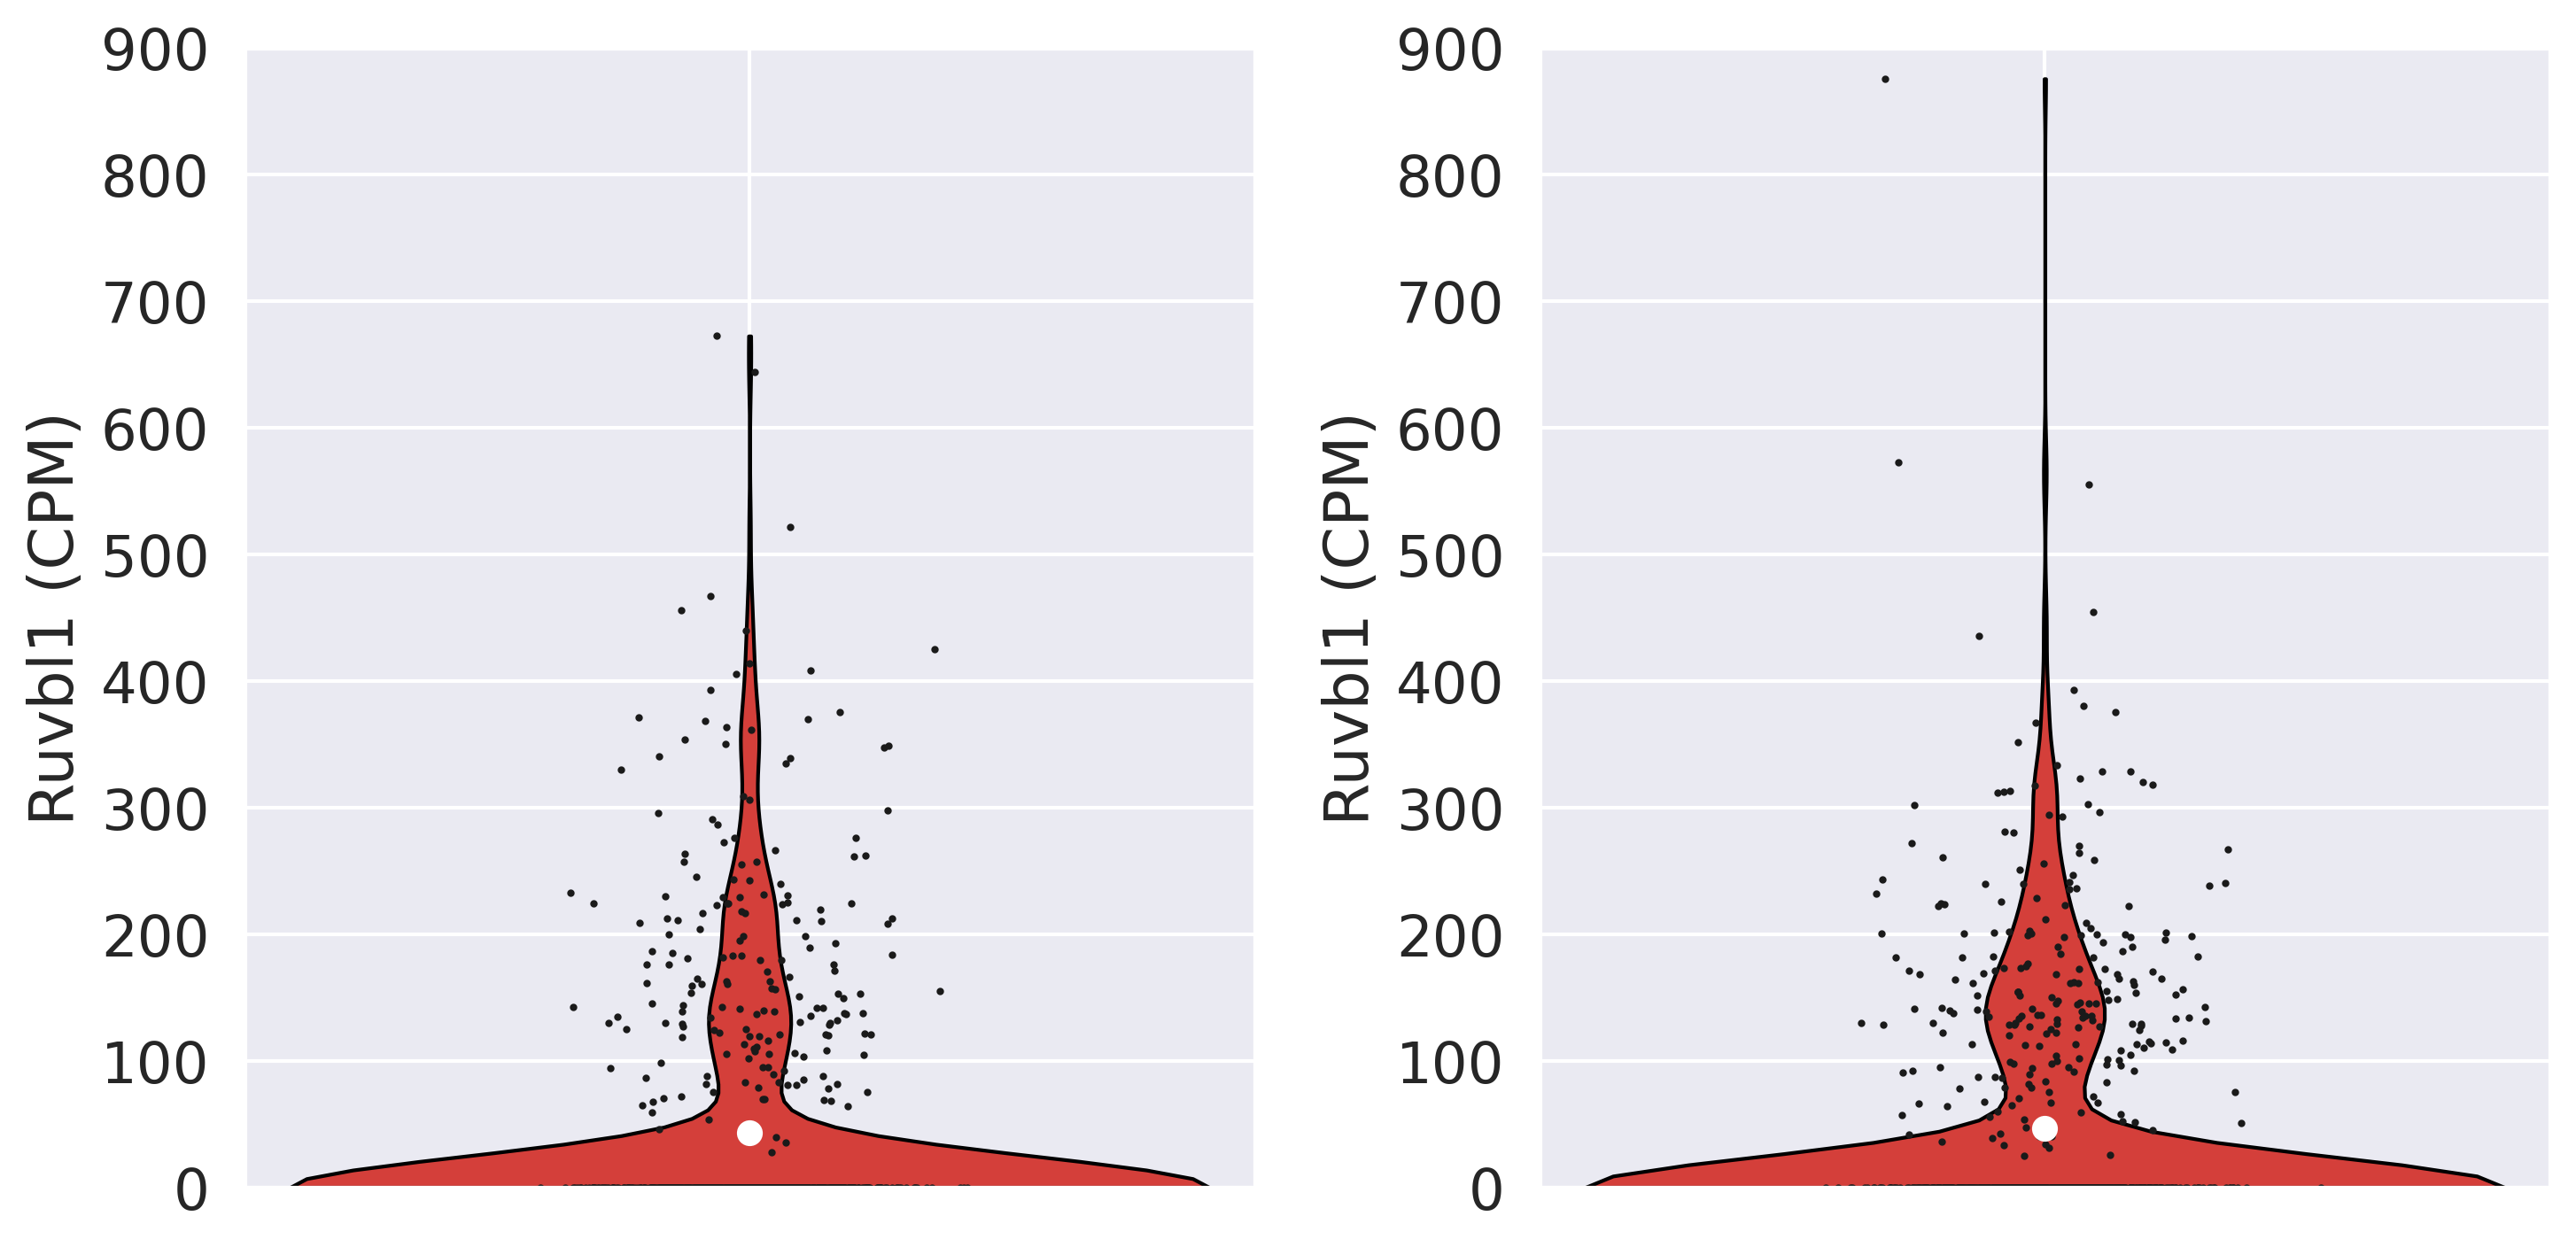

In [79]:
gene_symbol = "Ruvbl1"

fig, ax = plt.subplots(figsize=(5*2,5), ncols=2)

x1 = data_gene[data_gene.obs['id'].isin([key for key, value in mapping.items() if value == 0]), gene_name].X.toarray()
x2 = data_gene[data_gene.obs['id'].isin([key for key, value in mapping.items() if value == 1]), gene_name].X.toarray()

vplot(x1, ax[0])
vplot(x2, ax[1])

ax[0].set_ylabel('{} (CPM)'.format(gene_symbol))
ax[1].set_ylabel('{} (CPM)'.format(gene_symbol))
ax[0].set_ylim(0,900)
ax[1].set_ylim(0,900)

plt.tight_layout()
plt.show()

In [88]:
gene_name = 'ENSMUSG00000067274.11'

# Filter the var indices based on the presence of gene_name in the gene_names column
#selected_indices = data.var.index[data.var['gene_names'].str.contains(gene_name)]
selected_indices = data.var.index[data.var['gene_names'] == gene_name]

# Create a new anndata object that is a subset of the original data
subset_data = data[:, selected_indices].copy()

subset_data_0 = subset_data[subset_data.obs['id'].isin([key for key, value in mapping.items() if value == 0]), :]
subset_data_1 = subset_data[subset_data.obs['id'].isin([key for key, value in mapping.items() if value == 1]), :]

In [89]:
# Extract the counts matrix
counts_matrix_0 = subset_data_0.X.toarray()  # Convert to dense array if it's sparse
counts_matrix_1 = subset_data_1.X.toarray()  # Convert to dense array if it's sparse

# Get the gene (index) names and cell (obs) names
gene_names = subset_data.var.index
cell_names_0 = subset_data_0.obs.index
cell_names_1 = subset_data_1.obs.index

# Create a DataFrame for easier manipulation and plotting
heatmap_data_0 = pd.DataFrame(counts_matrix_0.T, index=gene_names, columns=cell_names_0)
heatmap_data_1 = pd.DataFrame(counts_matrix_1.T, index=gene_names, columns=cell_names_1)

# Filter the heatmap_data to keep only these cells

non_zero_cells = (heatmap_data_0 != 0).any(axis=0)
heatmap_data_0 = heatmap_data_0.loc[:, non_zero_cells]
non_zero_cells = (heatmap_data_1 != 0).any(axis=0)
heatmap_data_1 = heatmap_data_1.loc[:, non_zero_cells]


<Figure size 2100x600 with 0 Axes>

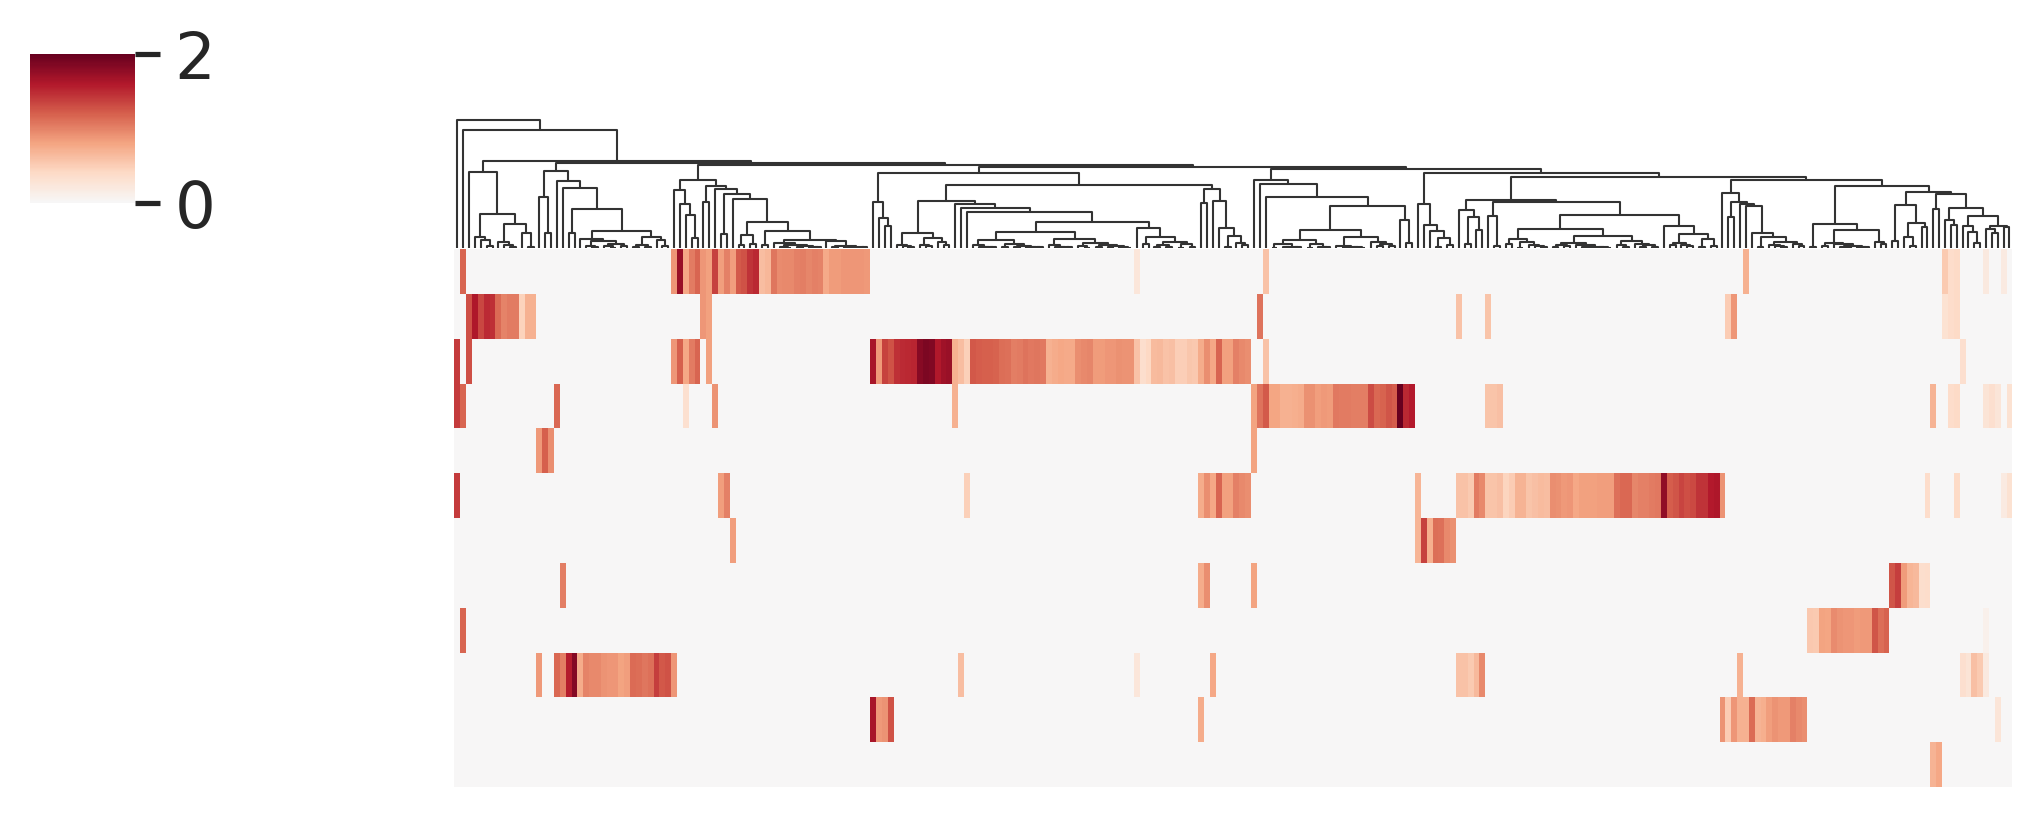

In [90]:
plot_data = heatmap_data_0.copy()
plt.figure(figsize=(7, 2))
num_ecs = len(list(plot_data.index))
yticklabels=list(map(chr, range(97, 97+num_ecs)))
sns.set(font_scale=1.4)
g = sns.clustermap(plot_data, metric="euclidean", method="average", cmap="RdBu_r", yticklabels=False,
               xticklabels=False, row_cluster=False, center=0, vmin=0, vmax=2.0, figsize=(7,2.75))
#plt.setp(g.ax_heatmap.get_yticklabels(), rotation=0)
plt.show()

In [91]:
[map_transcripts(ec_mapping[int(ec)]) for ec in list(heatmap_data_0.index)]

['ENSMUST00000086519.12',
 'ENSMUST00000086519.12,ENSMUSG00000067274.11',
 'ENSMUST00000086519.12,ENSMUST00000156359.2,ENSMUSG00000067274.11',
 'ENSMUST00000086519.12,ENSMUST00000156359.2',
 'ENSMUST00000152976.2,ENSMUST00000155584.2,ENSMUSG00000067274.11',
 'ENSMUSG00000067274.11',
 'ENSMUST00000086519.12,ENSMUST00000152976.2,ENSMUST00000155584.2',
 'ENSMUST00000152976.2,ENSMUSG00000067274.11',
 'ENSMUST00000086519.12,ENSMUST00000152976.2,ENSMUST00000156359.2,ENSMUSG00000067274.11',
 'ENSMUST00000086519.12,ENSMUST00000152976.2,ENSMUST00000155584.2,ENSMUST00000156359.2,ENSMUSG00000067274.11',
 'ENSMUST00000086519.12,ENSMUST00000152976.2,ENSMUST00000156359.2',
 'ENSMUST00000155584.2,ENSMUSG00000067274.11']

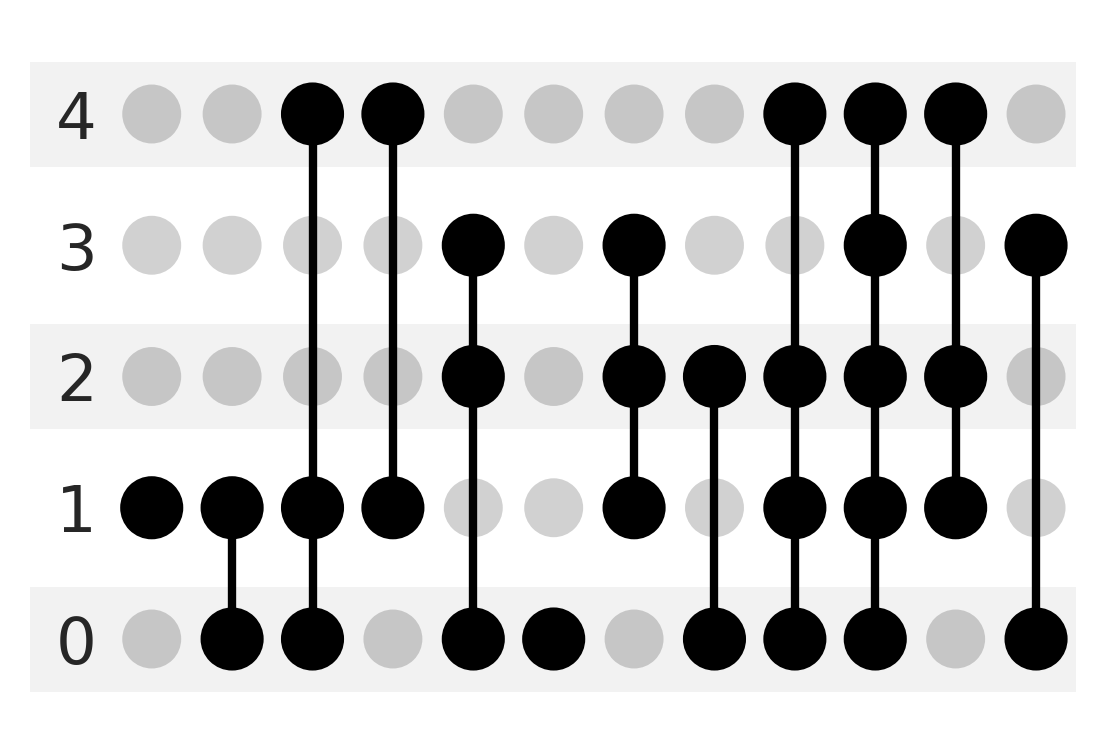

In [95]:
fig = plt.figure(figsize=(4.5, 3))
ud = {
    'Nascent Rplp0': '0',
    'Mature Rplp0 (ENSMUST00000086519)': '1',
    'Mature Rplp0 (ENSMUST00000152976)': '2',
    'Mature Rplp0 (ENSMUST00000155584)': '3',
    'Mature Rplp0 (ENSMUST00000156359)': '4'
}
example = upsetplot.from_memberships(
    [
     [ud['Mature Rplp0 (ENSMUST00000086519)']],
     [ud['Nascent Rplp0'], ud['Mature Rplp0 (ENSMUST00000086519)']],
     [ud['Nascent Rplp0'], ud['Mature Rplp0 (ENSMUST00000086519)'], ud['Mature Rplp0 (ENSMUST00000156359)']],
     [ud['Mature Rplp0 (ENSMUST00000086519)'], ud['Mature Rplp0 (ENSMUST00000156359)']],
     [ud['Nascent Rplp0'], ud['Mature Rplp0 (ENSMUST00000152976)'], ud['Mature Rplp0 (ENSMUST00000155584)']],
     [ud['Nascent Rplp0']],
     [ud['Mature Rplp0 (ENSMUST00000086519)'], ud['Mature Rplp0 (ENSMUST00000152976)'], ud['Mature Rplp0 (ENSMUST00000155584)']],
     [ud['Nascent Rplp0'], ud['Mature Rplp0 (ENSMUST00000152976)']],
     [ud['Nascent Rplp0'], ud['Mature Rplp0 (ENSMUST00000086519)'], ud['Mature Rplp0 (ENSMUST00000152976)'], ud['Mature Rplp0 (ENSMUST00000156359)']],
     [ud['Nascent Rplp0'], ud['Mature Rplp0 (ENSMUST00000086519)'], ud['Mature Rplp0 (ENSMUST00000152976)'], ud['Mature Rplp0 (ENSMUST00000155584)'], ud['Mature Rplp0 (ENSMUST00000156359)']],
     [ud['Mature Rplp0 (ENSMUST00000086519)'], ud['Mature Rplp0 (ENSMUST00000152976)'], ud['Mature Rplp0 (ENSMUST00000156359)']],
     [ud['Nascent Rplp0'], ud['Mature Rplp0 (ENSMUST00000155584)']]
    ],
    data=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
)
up = upsetplot.plot(example, sort_categories_by='input', fig=fig, element_size=None, sort_by='input', totals_plot_elements=0, intersection_plot_elements=0)

plt.show()


<Figure size 2100x600 with 0 Axes>

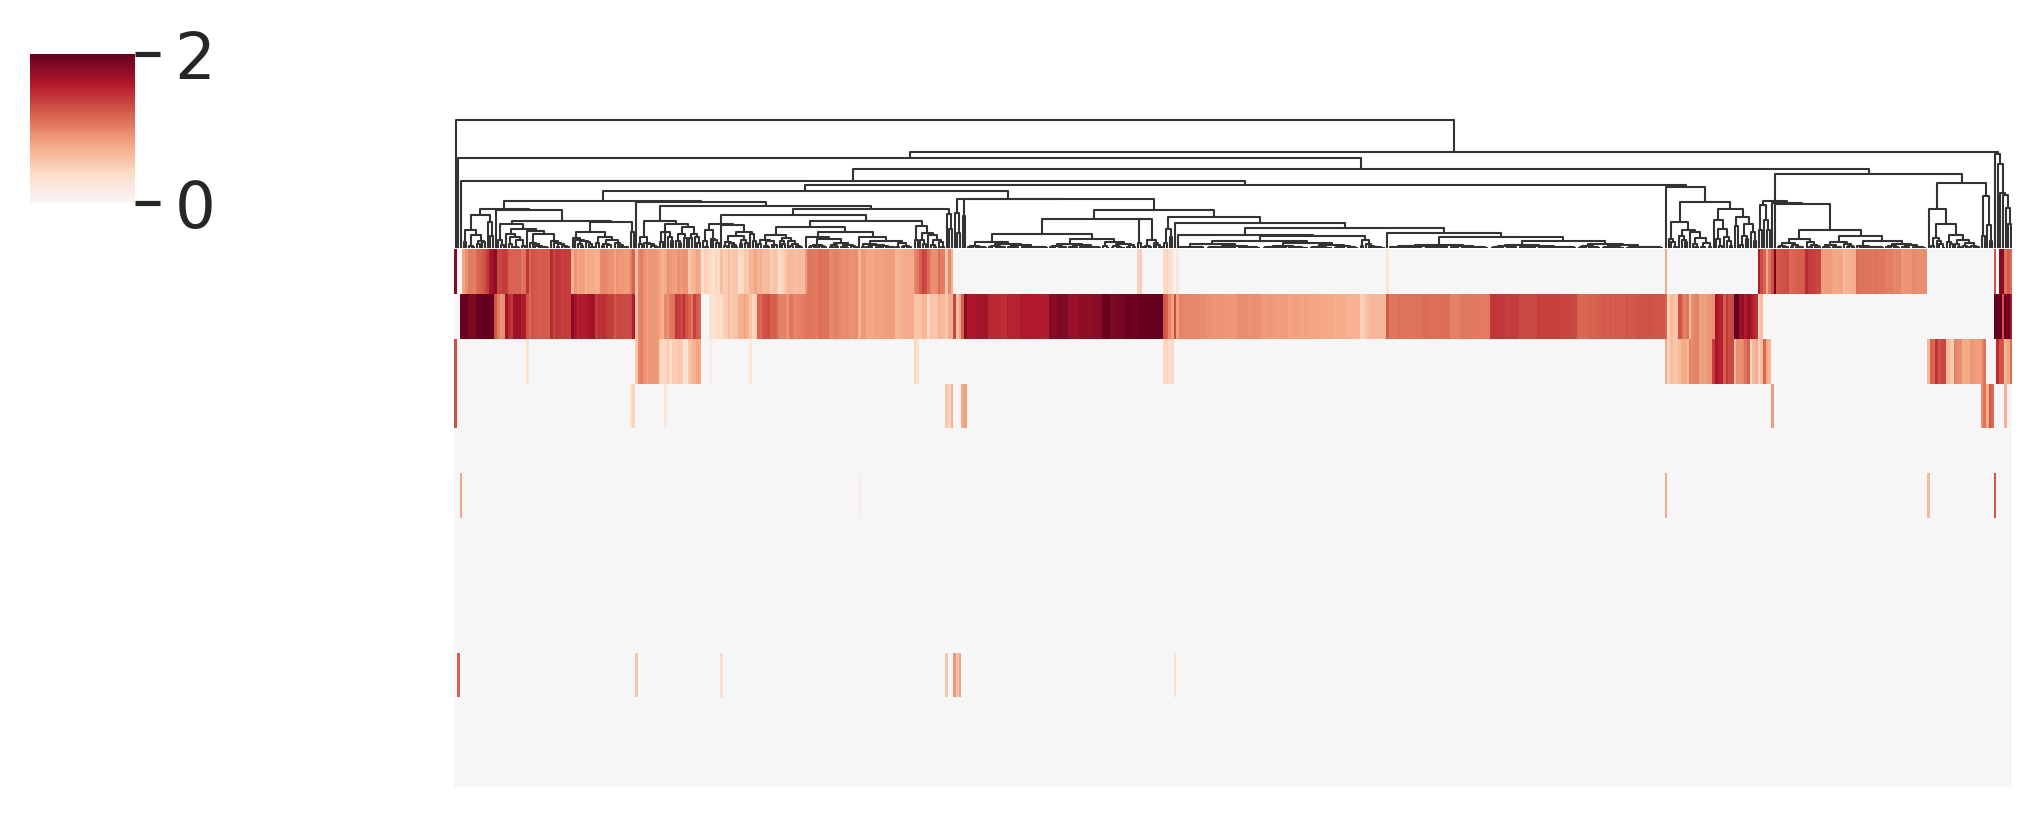

In [96]:
plot_data = heatmap_data_1.copy()
plt.figure(figsize=(7, 2))
num_ecs = len(list(plot_data.index))
yticklabels=list(map(chr, range(97, 97+num_ecs)))
sns.set(font_scale=1.4)
g = sns.clustermap(plot_data, metric="euclidean", method="average", cmap="RdBu_r", yticklabels=False,
               xticklabels=False, row_cluster=False, center=0, vmin=0, vmax=2.0, figsize=(7,2.75))
#plt.setp(g.ax_heatmap.get_yticklabels(), rotation=0)
plt.show()

In [97]:
[map_transcripts(ec_mapping[int(ec)]) for ec in list(heatmap_data_1.index)]

['ENSMUST00000086519.12',
 'ENSMUST00000086519.12,ENSMUSG00000067274.11',
 'ENSMUST00000086519.12,ENSMUST00000156359.2,ENSMUSG00000067274.11',
 'ENSMUST00000086519.12,ENSMUST00000156359.2',
 'ENSMUST00000152976.2,ENSMUST00000155584.2,ENSMUSG00000067274.11',
 'ENSMUSG00000067274.11',
 'ENSMUST00000086519.12,ENSMUST00000152976.2,ENSMUST00000155584.2',
 'ENSMUST00000152976.2,ENSMUSG00000067274.11',
 'ENSMUST00000086519.12,ENSMUST00000152976.2,ENSMUST00000156359.2,ENSMUSG00000067274.11',
 'ENSMUST00000086519.12,ENSMUST00000152976.2,ENSMUST00000155584.2,ENSMUST00000156359.2,ENSMUSG00000067274.11',
 'ENSMUST00000086519.12,ENSMUST00000152976.2,ENSMUST00000156359.2',
 'ENSMUST00000155584.2,ENSMUSG00000067274.11']

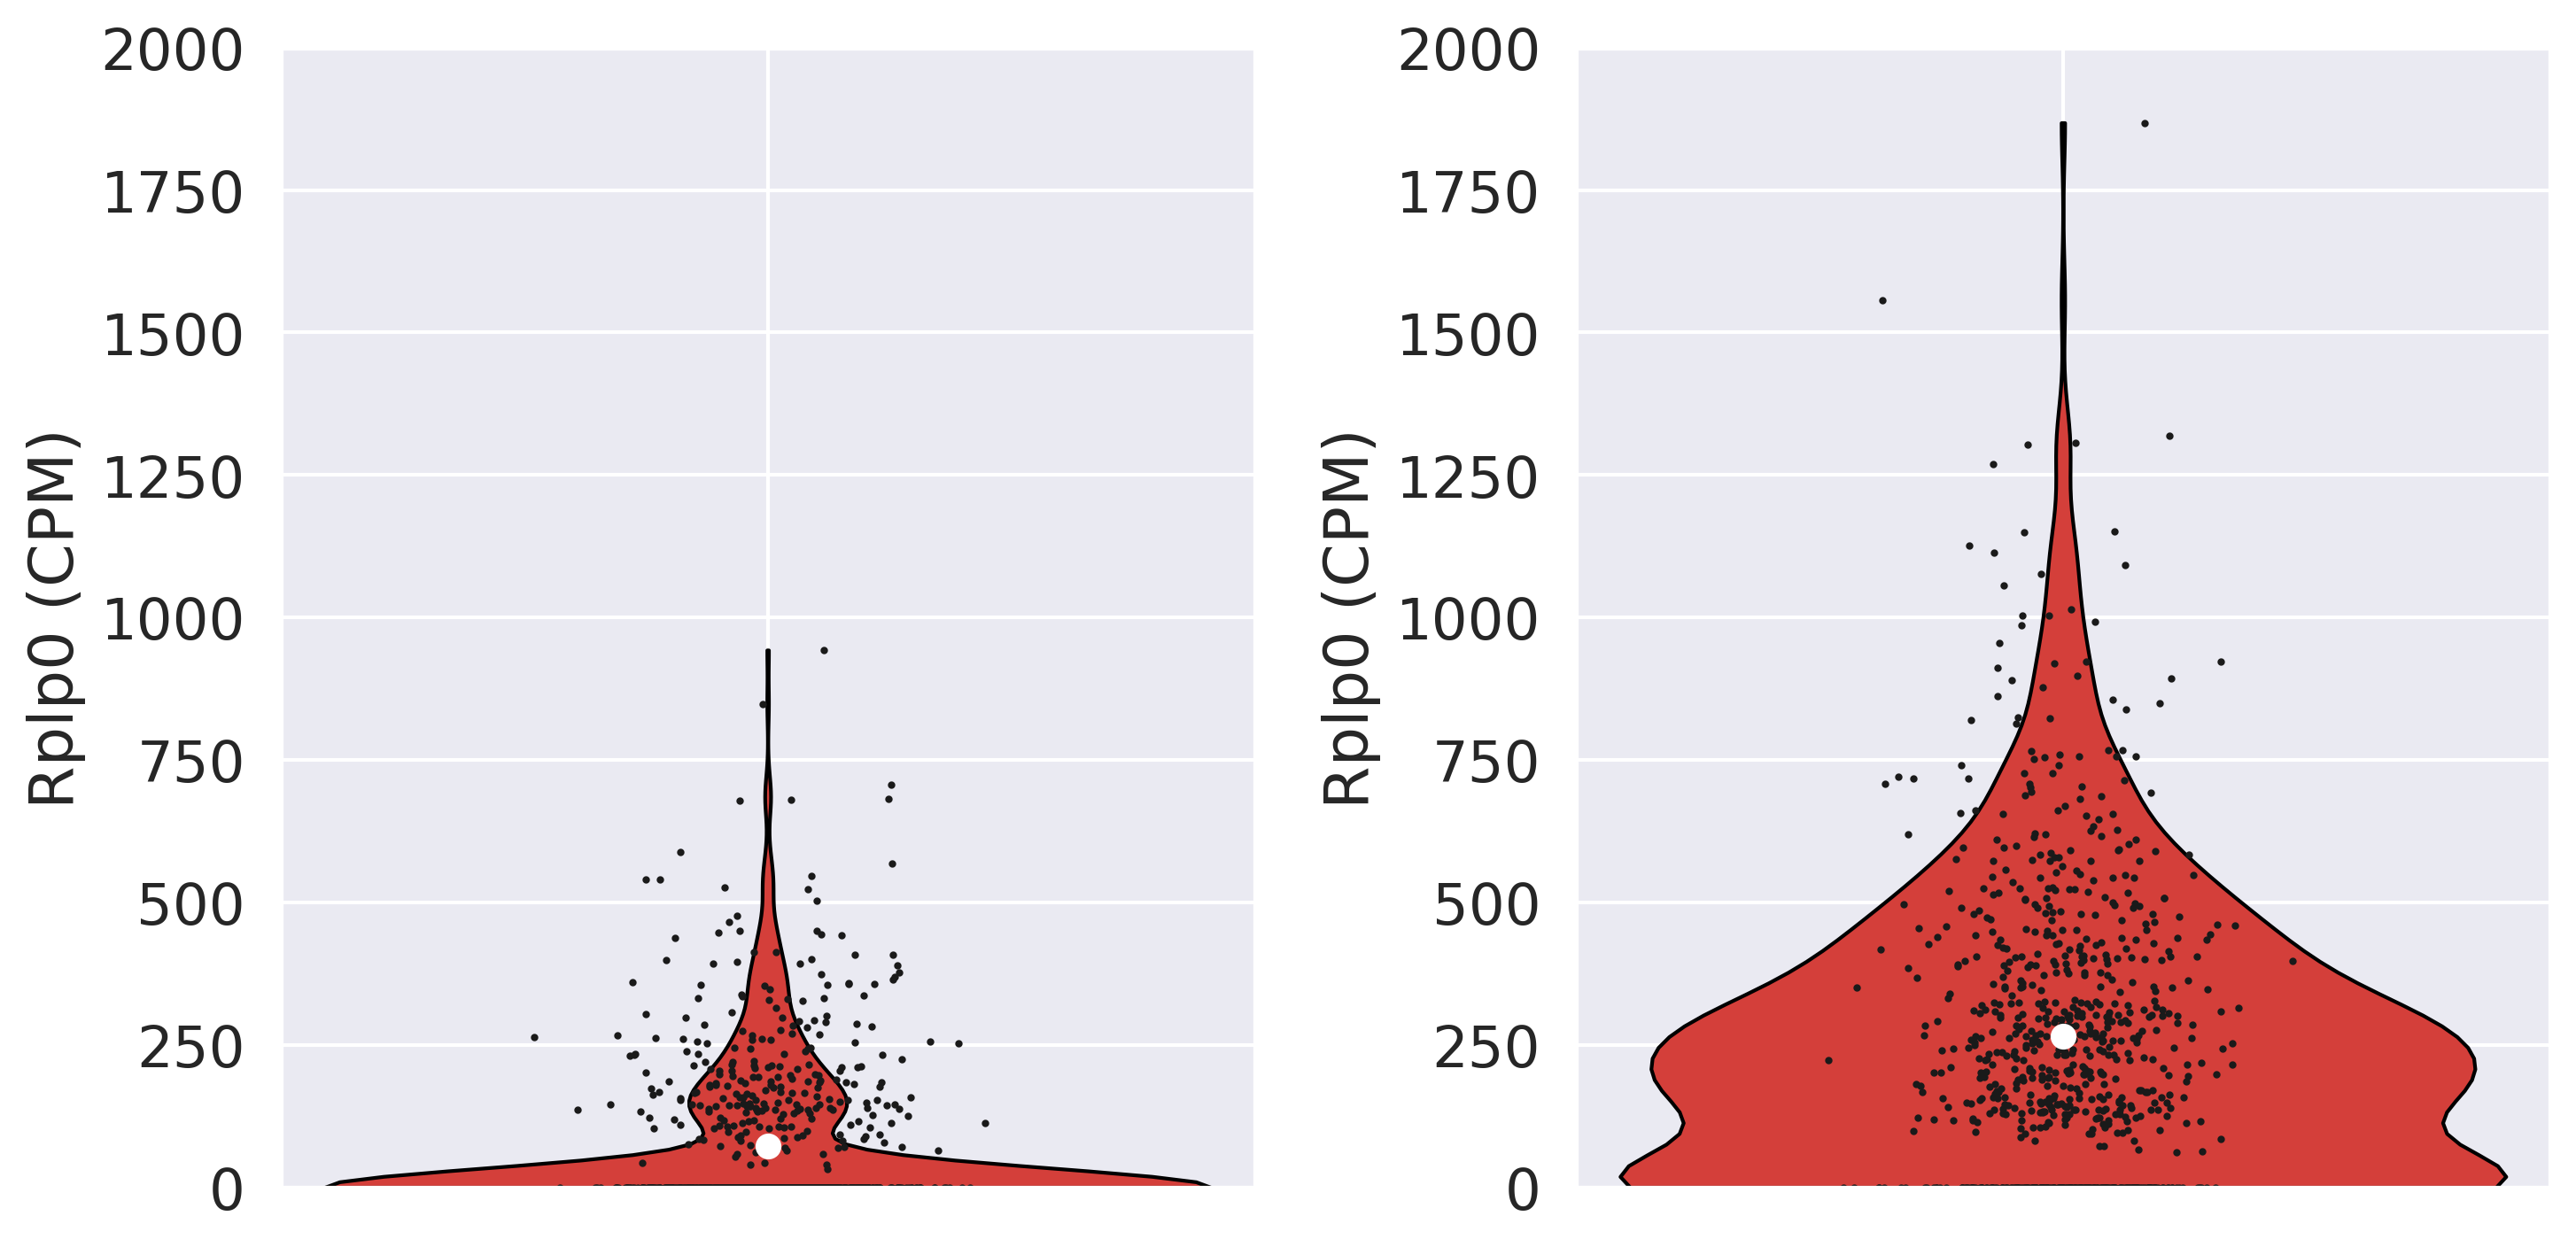

In [99]:
gene_symbol = "Rplp0"

fig, ax = plt.subplots(figsize=(5*2,5), ncols=2)

x1 = data_gene[data_gene.obs['id'].isin([key for key, value in mapping.items() if value == 0]), gene_name].X.toarray()
x2 = data_gene[data_gene.obs['id'].isin([key for key, value in mapping.items() if value == 1]), gene_name].X.toarray()

vplot(x1, ax[0])
vplot(x2, ax[1])

ax[0].set_ylabel('{} (CPM)'.format(gene_symbol))
ax[1].set_ylabel('{} (CPM)'.format(gene_symbol))
ax[0].set_ylim(0,2000)
ax[1].set_ylim(0,2000)

plt.tight_layout()
plt.show()